## LangGraph - Deepseek와 Qwen 연동

In [1]:
import requests

response = requests.get("http://127.0.0.1:11434")
print(response.text)

Ollama is running


In [4]:
from langchain_ollama import ChatOllama
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.prompts import ChatPromptTemplate

### LangGraph 를 사용하여 두개의 모델 연동

In [5]:
reasoning_model = ChatOllama(model="deepseek-r1:1.5b", temperature=0, stop=["</think>"])
print(reasoning_model)

model='deepseek-r1:1.5b' temperature=0.0 stop=['</think>']


In [ ]:
generation_model = ChatOllama(model="qwen2.5:1.5b", temperature=0.7)
print(generation_model)

model='qwen2.5:1.5b' temperature=0.7


In [8]:
answer_prompt = ChatPromptTemplate([
    (
        "system",
        """
        당신은 사용자의 질문에 대해 명확하고 포괄적인 답변을 제공하는 AI 어시스턴트입니다.

        당신의 작업은 다음과 같습니다:
        - 질문과 제공된 추론을 신중하게 분석하세요.
        - 추론에서 얻은 통찰력을 포함하여 잘 구조화된 답변을 생성하세요.
        - 답변이 사용자의 질문에 직접적으로 대응하도록 하세요.
        - 정보를 명확하고 자연스럽게 전달하되, 추론 과정을 명시적으로 언급하지 마세요.

        지침:
        - 답변을 대화 형식으로 작성하고, 흥미롭게 전달하세요.
        - 중요한 포인트를 모두 다루면서도 명확하고 간결하게 작성하세요.
        - 제공된 추론을 사용한다는 것을 언급하지 말고, 그 통찰력을 자연스럽게 포함시키세요.
        - 도움이 되고 전문적인 톤을 유지하세요.

        목표: 사용자의 질문에 직접적으로 대응하면서 추론 과정에서 얻은 통찰력을 자연스럽게 포함한 정보 제공입니다.
        """
    ),
    (
        "human",
        """
        질문: {question}
        추론: {thinking}
        """
    )
])

In [12]:
#LangGraph에서 State 사용자정의 클래스는 노드 간의 정보를 전달하는 틀입니다. 
#노드 간에 계속 전달하고 싶거나, 그래프 내에서 유지해야 할 정보를 미리 정의힙니다. 
class State(TypedDict):
    question: str
    thinking: str
    answer: str

In [9]:
#DeepSeek를 통해서 추론 부분까지만 생성합니다. 
def think(state: State):
    question = state["question"]
    response = reasoning_model.invoke(question)
    #print(response.content)
    return {"thinking": response.content}

#Qwen를 통해서 결과 출력 부분을 생성합니다.
def generate(state: State):
    messages = answer_prompt.invoke({"question": state["question"], "thinking": state["thinking"]})
    response = generation_model.invoke(messages)
    print(response.content)
    return {"answer": response.content}

In [ ]:
# 그래프 컴파일
graph_builder = StateGraph(State).add_sequence([think, generate])
# 시작은 think 함수부터
graph_builder.add_edge(START, "think")
graph = graph_builder.compile()

In [13]:
# 입력 데이터
inputs = {"question": "9.9와 9.11 중 무엇이 더 큰가요?"}

# invoke()를 사용하여 그래프 호출
result = graph.invoke(inputs)
print(result)

# 결과 출력
print("==> 생성된 답변: \n")
print(result["answer"])

9.9보다 9.11가 더 크다고 합니다. 이는 두 숫자의 일부를 비교해 보았을 때 나타납니다. 둘 다 9로 시작하는 것이므로, 첫 번째 자리에서 9와 9를 비교했습니다. 9.11은 0.1라는 의미입니다. 따라서, 9.9와 9.11을 천과 페인트 단위로 나타냈고, 둘의 10분의 1 자리를 살펴보았습니다. 9.11의 10분의 1은 1이지만, 9.9의 10분의 1은 9입니다. 이에 따라 9.9는 9.11보다 더 크다고 판단됩니다.
{'question': '9.9와 9.11 중 무엇이 더 큰가요?', 'thinking': "<think>\nFirst, I need to compare the two numbers: 9.9 and 9.11.\n\nBoth numbers have the same whole number part, which is 9.\n\nTo make a fair comparison, I'll align their decimal places by writing 9.9 as 9.90.\n\nNow, comparing each digit from left to right:\n\n- The units place for both numbers is 9.\n- In the tenths place, 9 has a 9 and 9.11 has a 1.\n- Since 9 is greater than 1 in the tenths place, 9.90 is larger than 9.11.\n\nTherefore, 9.9 is greater than 9.11.\n", 'answer': '9.9보다 9.11가 더 크다고 합니다. 이는 두 숫자의 일부를 비교해 보았을 때 나타납니다. 둘 다 9로 시작하는 것이므로, 첫 번째 자리에서 9와 9를 비교했습니다. 9.11은 0.1라는 의미입니다. 따라서, 9.9와 9.11을 천과 페인트 단위로 나타냈고, 둘의 10분의 1 자리를 살펴보았습니다. 9.11의 10분의 1은 1이지만, 9.9의 10분의 1은 9입니다. 이에 따라 9.9는 

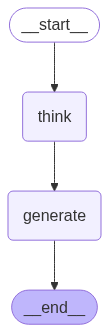

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
            curve_style=CurveStyle.CARDINAL
        )        
    )
)

In [ ]:
inputs = {"question": "9.9와 9.11 중 무엇이 더 큰가요?"}

async for event in graph.astream_events(inputs, version="v2"):
    kind = event["event"]
    if kind == "on_chat_model_stream":
        print(event['data']['chunk'].content, end="", flush=True)